<a href="https://colab.research.google.com/github/danielabebe1/Capstone2/blob/master/Exploring_Dicom_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Dicom Images

## Import Packages

In [2]:
#https://www.programcreek.com/python/example/97517/dicom.read_file
# https://www.programcreek.com/python/?code=xf4j%2Faapm_thoracic_challenge%2Faapm_thoracic_challenge-master%2Fconvert_data.py

!pip install pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import glob
import tqdm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans

     |████████████████████████████████| 35.5MB 105kB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#connect the google drive to the google colab
from google.colab import drive
drive.mount('/content/drive')
#Directories
image_train='/content/drive/My Drive/OSIC Pulmonary Fibrosis/train/'
Patients=os.listdir(image_train)
image_test='/content/drive/My Drive/OSIC Pulmonary Fibrosis/test/'
train_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/train.csv'
test_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/test.csv'
sub_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/sample_submission.csv'
#read csv
train=pd.read_csv(train_csv)
test=pd.read_csv(test_csv)
sub=pd.read_csv(sub_csv)
sub[['Patient','Weeks']]=sub.Patient_Week.str.split("_",expand = True)
#creating path column for dcm files of patient
train['Path']=image_train + train['Patient']


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Text(0.5, 1.0, '# of DICOM per patient of Training Data')

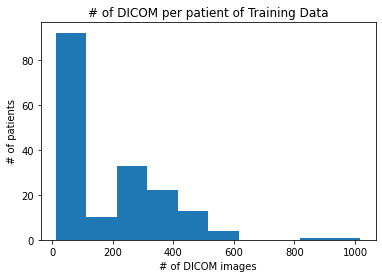

In [ ]:
# Number of dcm images for each patient
dcm_each_patient = [] 
for d in os.listdir(image_train):
    dcm_each_patient.append(len(os.listdir(image_train + d)))
  # lets visualize trainig data
plt.hist(dcm_each_patient)
plt.ylabel('# of patients')
plt.xlabel('# of DICOM images')
#ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.title('# of DICOM per patient of Training Data')

In [ ]:
#Let's read dicom file
d='/content/drive/My Drive/OSIC Pulmonary Fibrosis/train/ID00007637202177411956430/1.dcm'
dicom.dcmread(d)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.12297650151329871895440507938349160734
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.12297650151329871895440507938349160734
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 

Let's make two helper functions.
(https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/)
> ***load_dcm*** will load all DICOM images from a folder into a list for manipulation.

> The voxel values in the images are raw. ***get_pixels_hu*** converts raw values into Houndsfeld units

*   The transformation is linear. Therefore, so long as you have a slope and an intercept, you can rescale a voxel value to HU.
*   Both the rescale intercept and rescale slope are stored in the DICOM header at the time of image acquisition (these values are scanner-dependent, so you will need external information).




In [ ]:
#https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

# Load the dcm in given folder path
def load_dcm(path):
    scans = os.listdir(path)
    slices = []
    
    for scan in scans:
        with dicom.dcmread(path + '/' + scan) as s:
            slices.append(s)
    
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            slice_thickness = slices[0].SliceThickness
    
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [ ]:
def get_pixels_hu(dcms):
    image = np.stack([s.pixel_array for s in dcms])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    intercept = dcms[0].RescaleIntercept
    slope = dcms[0].RescaleSlope
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)     
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)

(-0.5, 511.5, 511.5, -0.5)

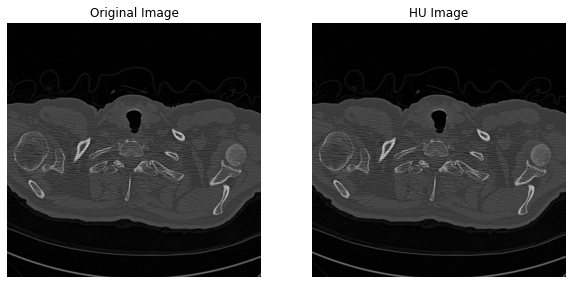

In [ ]:
patient = load_dcm(image_train + Patients[0])
image = get_pixels_hu(patient)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].set_title('Original Image')
ax[0].imshow(patient[15].pixel_array, cmap='gray')
ax[0].axis('off')

ax[1].set_title('HU Image')
ax[1].imshow(image[15], cmap='gray')
ax[1].axis('off')

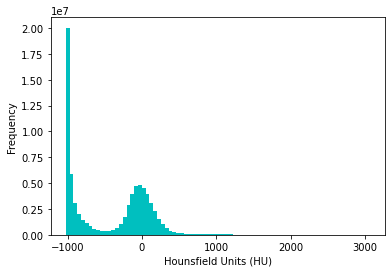

In [ ]:
# Let's have a look at the distribution of pixels in the images converted to Hounsfield Units.
plt.hist(image.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

Checking with the HU table shows:

*   There is a lot of air, the peak around -1000
*   At around -500 there are some pixels classified as Lung;
*   The smaller gaussian-shaped peak at 0 indicates soft tissues;
*   The distribution tail from 700 onward shows the presence of bones.





Displaying an image

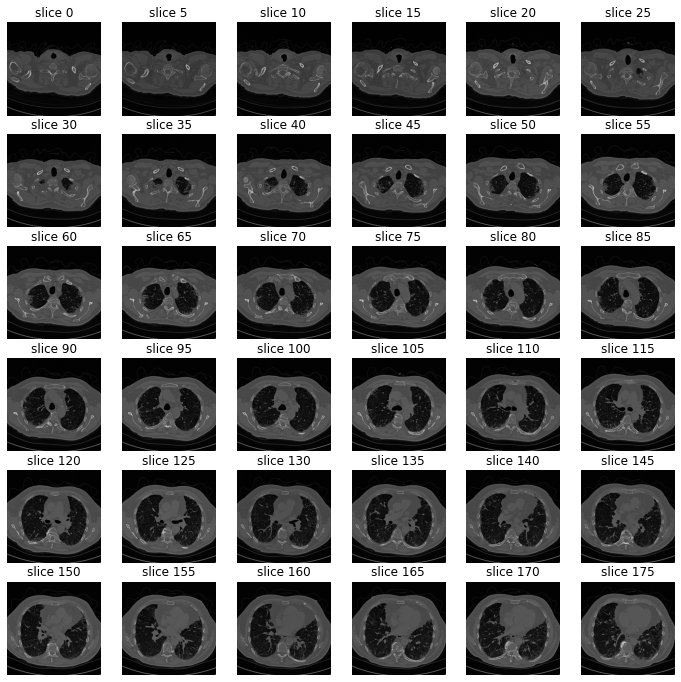

In [ ]:
def sample_stack(stack, rows=6, cols=6, start_with=0, show_every=5):
  fig,ax = plt.subplots(rows,cols,figsize=[12,12])
  for i in range(rows*cols):
    ind = start_with + i*show_every
    ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
    ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
    ax[int(i/rows),int(i % rows)].axis('off')
  plt.show()

sample_stack(image)

Apply

In [ ]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 1.000000
Pixel Spacing (row, col): (0.693359, 0.693359) 


In [ ]:

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [ ]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (290, 512, 512)
Shape after resampling	 (290, 355, 355)


In [ ]:
def plot_3d(image, threshold=-300, step_size=1,):
    p = image.transpose(2,1,0)
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, allow_degenerate=True)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[facesnm, ` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

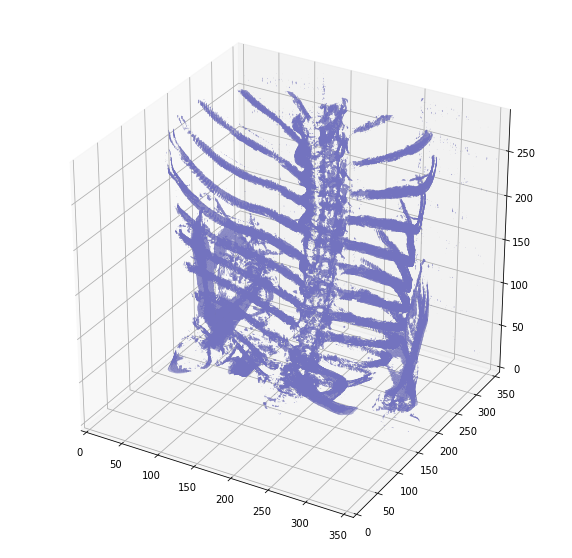

In [ ]:
plot_3d(pix_resampled, 1000)

In [ ]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    biggest = vals[np.argmax(counts)]
    return biggest

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    # Method of filling the lung structures (that is superior to something like morphological closing)
    if fill_lung_structures:
      # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [ ]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

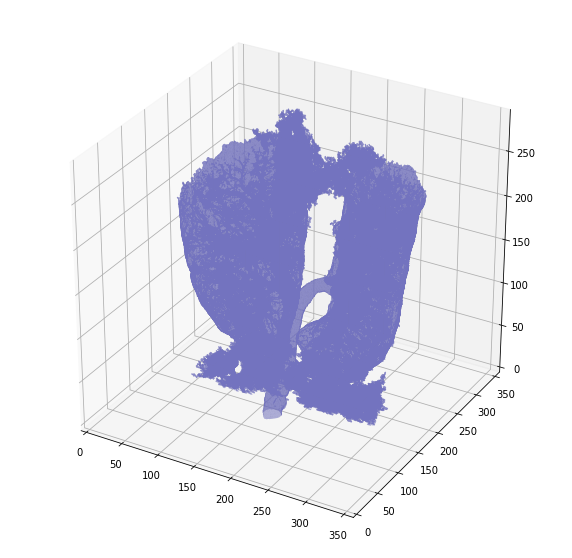

In [ ]:
plot_3d(segmented_lungs, 0)

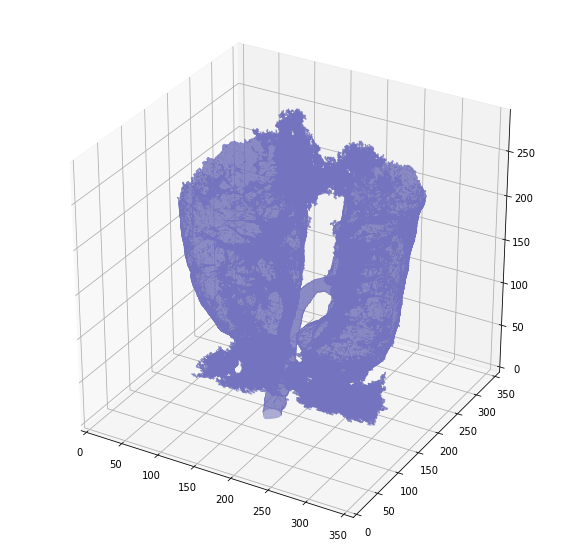

In [ ]:
plot_3d(segmented_lungs_fill, 0)

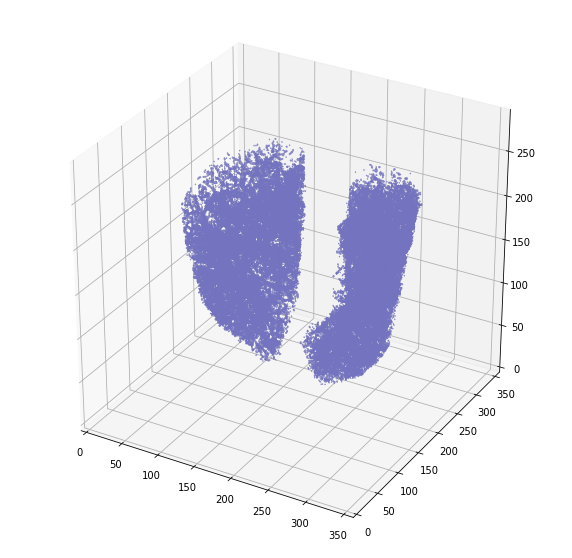

In [ ]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

In [4]:
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
        # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
     # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
      # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0
    
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    
    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img


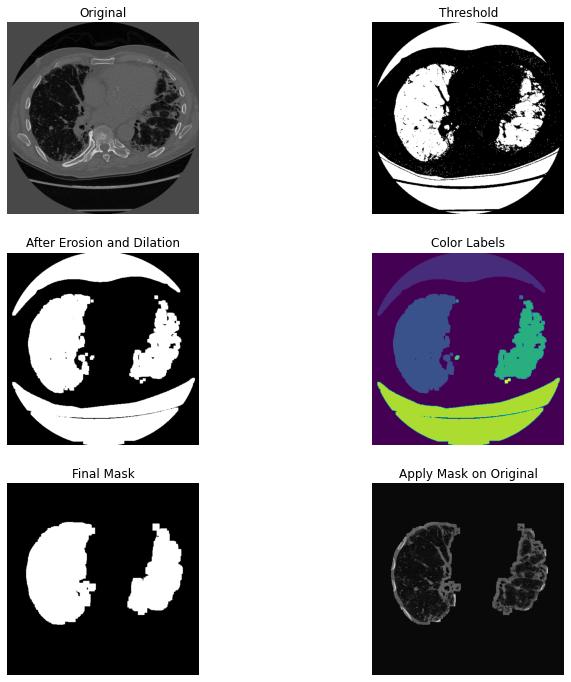

In [5]:
# Select a sample
path = "/content/drive/My Drive/OSIC Pulmonary Fibrosis/train/ID00007637202177411956430/19.dcm"
dcm = dicom.dcmread(path)
img = dcm.pixel_array

# Masked image
mask_img = make_lungmask(img, display=True)

The pixel array difference before and after masking

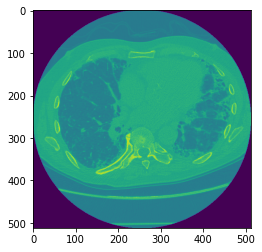

In [7]:
plt.imshow(img)

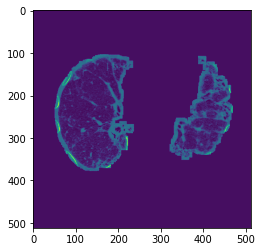

In [8]:
plt.imshow(make_lungmask(img))

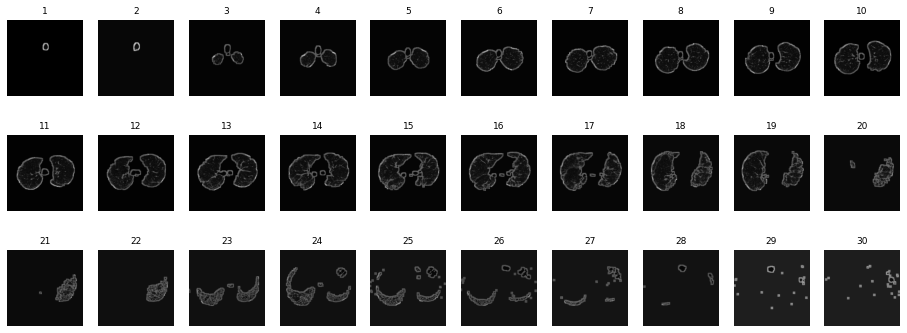

In [ ]:
patient_dir = "/content/drive/My Drive/OSIC Pulmonary Fibrosis/train/ID00007637202177411956430"
datasets = []

# First Order the files in the dataset
files = []
for dcm in list(os.listdir(patient_dir)):
    files.append(dcm) 
files.sort(key=lambda f: int(re.sub('\D', '', f)))

# Read in the Dataset
for dcm in files:
    path = patient_dir + "/" + dcm
    datasets.append(dicom.dcmread(path))
    
imgs = []
for data in datasets:
    img = data.pixel_array
    imgs.append(img)

# Show masks
fig=plt.figure(figsize=(16, 6))
columns = 10
rows = 3

for i in range(1, columns*rows +1):
    img = make_lungmask(datasets[i-1].pixel_array)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
    plt.title(i, fontsize = 9)
    plt.axis('off');

In [ ]:
import pickle
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/dcm_meta_data.pkl"
infile = open(DATA_PATH,'rb')
mod = pickle.load(infile)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mod.head()


,FileNumber,Rows,Columns,PatientID,BodyPartExamined,RotationDirection,ConvolutionKernel,PatientPosition,PhotometricInterpretation,Modality,StudyInstanceUID,PixelPaddingValue,SamplesPerPixel,BitsAllocated,BitsStored,HighBit,PixelRepresentation,RescaleType,SliceThickness,KVP,DistanceSourceToDetector,DistanceSourceToPatient,GantryDetectorTilt,TableHeight,XRayTubeCurrent,GeneratorPower,WindowCenter,WindowWidth,SliceLocation,RescaleIntercept,RescaleSlope,ImagePositionPatient,ImageOrientationPatient,ImageType,PixelSpacing
0,train,512,512,ID00423637202312137826377,Chest,CW,D,FFS,MONOCHROME2,CT,2.25.6467547893362082811063392930232473743,NaN,1,16,12,11,0,None,1,120,NaN,NaN,0.0,142,218.0,NaN,-500,-1500,-984.0,-1024,1,"[-188.5, -56.5, 984.300049]","[1, 0, 0, 0, 1, 0]","['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']","[0.693359375, 0.693359375]"
1,train,512,512,ID00423637202312137826377,Chest,CW,D,FFS,MONOCHROME2,CT,2.25.6467547893362082811063392930232473743,NaN,1,16,12,11,0,None,1,120,NaN,NaN,0.0,142,220.0,NaN,-500,-1500,-986.0,-1024,1,"[-188.5, -56.5, 986.300049]","[1, 0, 0, 0, 1, 0]","['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']","[0.693359375, 0.693359375]"
2,train,512,512,ID00423637202312137826377,Chest,CW,D,FFS,MONOCHROME2,CT,2.25.6467547893362082811063392930232473743,NaN,1,16,12,11,0,None,1,120,NaN,NaN,0.0,142,219.0,NaN,-500,-1500,-985.0,-1024,1,"[-188.5, -56.5, 985.300049]","[1, 0, 0, 0, 1, 0]","['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']","[0.693359375, 0.693359375]"
3,train,512,512,ID00423637202312137826377,Chest,CW,D,FFS,MONOCHROME2,CT,2.25.6467547893362082811063392930232473743,NaN,1,16,12,11,0,None,1,120,NaN,NaN,0.0,142,217.0,NaN,-500,-1500,-983.0,-1024,1,"[-188.5, -56.5, 983.300049]","[1, 0, 0, 0, 1, 0]","['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']","[0.693359375, 0.693359375]"
4,train,512,512,ID00423637202312137826377,Chest,CW,D,FFS,MONOCHROME2,CT,2.25.6467547893362082811063392930232473743,NaN,1,16,12,11,0,None,1,120,NaN,NaN,0.0,142,214.0,NaN,-500,-1500,-979.0,-1024,1,"[-188.5, -56.5, 979.300049]","[1, 0, 0, 0, 1, 0]","['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']","[0.693359375, 0.693359375]"


In [ ]:
mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33004 entries, 0 to 33003
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   FileNumber                 33004 non-null  object 
 1   Rows                       33004 non-null  int64  
 2   Columns                    33004 non-null  int64  
 3   PatientID                  33004 non-null  object 
 4   BodyPartExamined           33004 non-null  object 
 5   RotationDirection          33004 non-null  object 
 6   ConvolutionKernel          33004 non-null  object 
 7   PatientPosition            33004 non-null  object 
 8   PhotometricInterpretation  33004 non-null  object 
 9   Modality                   33004 non-null  object 
 10  StudyInstanceUID           33004 non-null  object 
 11  PixelPaddingValue          5013 non-null   float64
 12  SamplesPerPixel            33004 non-null  int64  
 13  BitsAllocated              33004 non-null  int

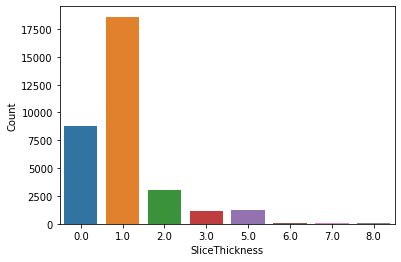

In [ ]:
tmp = mod['SliceThickness'].astype('float').value_counts().to_frame().reset_index().sort_values(by = 'index')
tmp.columns = ['SliceThickness','Count']
ax = sns.barplot(y='Count', x = 'SliceThickness',  data=tmp)

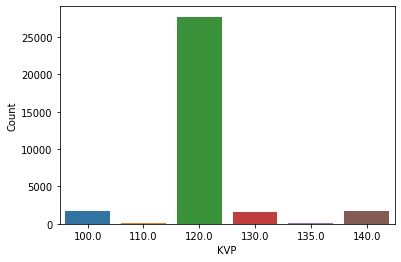

In [ ]:
tmp = mod['KVP'].astype('float').value_counts().to_frame().reset_index().sort_values(by = 'index')
tmp.columns = ['KVP','Count']
ax = sns.barplot(y='Count', x = 'KVP',  data=tmp)

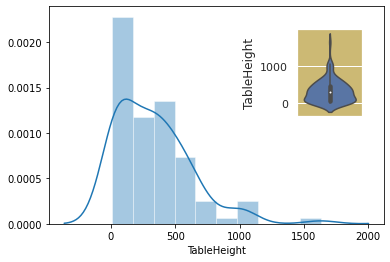

In [ ]:
fig, ax = plt.subplots()

tmp = mod['TableHeight'].astype('float').value_counts().to_frame().reset_index().sort_values(by = 'index')
sns.set(rc={'figure.figsize':(20,10)})
sns.distplot(tmp["TableHeight"])

ax2 = plt.axes([0.7, 0.5, .15, .3], facecolor='y')
ax2 = sns.violinplot(y=tmp["TableHeight"],  ax=ax2)

In [ ]:
df = mod.merge(train , left_on='PatientID', right_on='Patient')